# Question 5

## Step 1: Ask

The purpose of this step is to define the problem and understanding the stakeholder's expectations. In this case, I want to look at some sale trends, cateogry performance and insights, and find out how customer loyalty impact sales. How can we improve underperforming category? Can customer loyalty campaigns help with sales?

Some questions to ask are...
1. How much revenue is generated between each segment and category for all active segment? 
3. Which category has the most loyal customer and how does that category perform compare to other category?

## Step 2: Prepare

We are going to use all three tables in the sample database to answer our questions, I will mainly use this jupyter notebook to document my steps and findings.

In order to load the data for analysis, I first export each table from the sample.db to a csv file using sqlite3 with the command .output, then I will be able to use pandas to load the data into this workplace.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
trans_df = pd.read_csv('data/transactions.csv')
prod_df = pd.read_csv('data/products.csv')
seg_df = pd.read_csv('data/segments.csv')

In [3]:
trans_df.head(10)

,trans_id,trans_dt,cust_id,prod_id,item_qty,item_price
0,1,2016-01-02 10:06:00,9085146,223029,1,42.99
1,2,2016-01-02 10:30:00,1215814,252270,1,103.95
2,2,2016-01-02 10:30:00,1215814,260383,1,74.99
3,4,2016-01-02 11:33:00,18511160,269119,1,51.99
4,4,2016-01-02 11:33:00,18511160,411162,1,59.99
5,6,2016-01-02 11:35:00,15251041,251678,1,61.99
6,7,2016-01-02 11:36:00,14769966,218373,1,49.99
7,7,2016-01-02 11:36:00,14769966,243278,1,23.49
8,9,2016-01-02 11:55:00,5904487,258744,1,38.99
9,10,2016-01-02 12:16:00,3769351,255802,1,32.99


In [4]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trans_id    2666 non-null   int64  
 1   trans_dt    2666 non-null   object 
 2   cust_id     2666 non-null   int64  
 3   prod_id     2666 non-null   int64  
 4   item_qty    2666 non-null   int64  
 5   item_price  2666 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 125.1+ KB


## Step 3: Process

This is where I clean the data and making sure that the data are consistent.

Check for NaN value

In [5]:
print(
trans_df.isna().values.any(),
prod_df.isna().values.any(),
seg_df.isna().values.any())

False False False


In [6]:
print(
trans_df.isnull().values.any(),
prod_df.isnull().values.any(),
seg_df.isnull().values.any())

False False False


Check for duplicate transactions

In [7]:
trans_df[trans_df.duplicated(keep=False)]

,trans_id,trans_dt,cust_id,prod_id,item_qty,item_price
1619,1620,2016-01-02 11:02:00,9960002,223909,1,31.99
1620,1620,2016-01-02 11:02:00,9960002,223909,1,31.99


In [8]:
trans_df = trans_df.drop_duplicates()

Check for any duplicated product id

In [9]:
prod_df[prod_df.duplicated('prod_id',keep=False)]

,prod_id,prod_name,brand,category


Changing the data type to corresponding columns

In [10]:
trans_df['trans_dt'] = pd.to_datetime(trans_df['trans_dt'])
seg_df['update_at'] = pd.to_datetime(seg_df['update_at'])
trans_df.info()
seg_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 0 to 2665
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trans_id    2665 non-null   int64         
 1   trans_dt    2665 non-null   datetime64[ns]
 2   cust_id     2665 non-null   int64         
 3   prod_id     2665 non-null   int64         
 4   item_qty    2665 non-null   int64         
 5   item_price  2665 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 145.7 KB


,cust_id,seg_name,update_at,active_flag
0,4402,ONE-OFFS,2014-06-01,N
1,4402,LAPSED,2015-12-01,N
2,4402,LAPSED,2015-06-01,N
3,4402,LAPSED,2014-01-01,N
4,4402,ONE-OFFS,2016-02-01,Y
...,...,...,...,...
6119,21233469,NEW,2016-02-01,Y
6120,21233549,NEW,2016-02-01,Y
6121,21233596,NEW,2016-02-01,Y
6122,21233911,NEW,2016-02-01,Y


By the sametic meaning of seg_name, each customer should only has one active flag, meaning only one active segment for each customer. Check if a customer has more than one active_flag.

In [11]:
seg_df[seg_df.active_flag=='Y']['cust_id'].count() - seg_df['cust_id'].nunique()

322

We have 322 customers with more than one active flag, I'm going to keep only the latest update if a customer has 2 or more active flag.

In [12]:
seg_df = (seg_df[seg_df.active_flag=='Y'].sort_values('update_at', ascending=False).drop_duplicates('cust_id')).append(seg_df[seg_df.active_flag=='N'])
seg_df.sort_values('cust_id')
seg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5802 entries, 2254 to 6081
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   cust_id      5802 non-null   int64         
 1   seg_name     5802 non-null   object        
 2   update_at    5802 non-null   datetime64[ns]
 3   active_flag  5802 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 226.6+ KB


## Step 4: Analyze 

### 1. Sale Trends

After some basic clean up, I used excel to generate a pivot table to help me find monthly revenue and trend. The first thing I noticed is the sale number on 2016-01-02 had way more sales compare to any other day. This can be caused by many reason, but without any additional information, I decided to filter out the sale from that day to make a more accurate sales trend. 

Steps and findings can be found in the excel file named "master".

After ploting the monthly sales revenue, I notice there is a consistent growth over the last six months. Next, I digged deeper into each category and look at their performance in term of the monthly revenue.

In the month of May, men category has been down for 7%. On the other hand, Men only make up 15% of the overall revenue. With this in mind, lets look for the reason behind this.

### 2. Customer loyalty Impact

I want to first find out how much revenue is generated between each segment and category. First we are going to merge transaction with active segments according to customer ID. Secondly, we need to quantify loyality level by ranking them, so that we would measure how loyality customers spend money on different category.

In [13]:
merge_df = trans_df.merge(prod_df, how='left',on='prod_id',suffixes=('_x', '_y'))
merge_df = merge_df.merge(seg_df[seg_df.active_flag=='Y'], how='left', on='cust_id')

In [14]:
seg_df['seg_name'].unique()

array(['ONE-OFFS', 'VIP', 'LOYAL', 'INFREQUENT', 'NEW', 'INACTIVE',
       'LAPSED', 'GONE AWAY'], dtype=object)

Assign loyality ranking - Assumption: by sematic meaning of segments name, we will rank them by VIP > LOYAL > INFREQUENT > ONE-OFFS > NEW > INACTIVE > LAPSED.

In [15]:
merge_df['rank'] = merge_df['seg_name'].replace({'VIP':5,'LOYAL':4,'INFREQUENT':3, 'ONE-OFFS':2, 'NEW':1, 'INACTIVE':2, 'LAPSED':1, 'GONE AWAY':0})
merge_df['total'] = merge_df.item_qty*merge_df.item_price
merge_df

,trans_id,trans_dt,cust_id,prod_id,item_qty,item_price,prod_name,brand,category,seg_name,update_at,active_flag,rank,total
0,1,2016-01-02 10:06:00,9085146,223029,1,42.99,Product 223029,L,Make up,ONE-OFFS,2016-02-01,Y,2,42.99
1,2,2016-01-02 10:30:00,1215814,252270,1,103.95,Product 252270,R,Women,INFREQUENT,2016-02-01,Y,3,103.95
2,2,2016-01-02 10:30:00,1215814,260383,1,74.99,Product 260383,C,Women,INFREQUENT,2016-02-01,Y,3,74.99
3,4,2016-01-02 11:33:00,18511160,269119,1,51.99,Product 269119,L,Women,ONE-OFFS,2016-02-01,Y,2,51.99
4,4,2016-01-02 11:33:00,18511160,411162,1,59.99,Product 411162,K,Women,ONE-OFFS,2016-02-01,Y,2,59.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,2662,2016-06-18 10:00:00,3649704,354724683,1,49.99,Product 354724683,D,Men,VIP,2016-05-01,Y,5,49.99
2661,2662,2016-06-18 10:00:00,3649704,365543537,1,30.99,Product 365543537,L,Women,VIP,2016-05-01,Y,5,30.99
2662,2662,2016-06-18 10:00:00,3649704,364872356,1,41.99,Product 364872356,L,Sun,VIP,2016-05-01,Y,5,41.99
2663,2665,2016-06-18 17:51:00,4095901,277123,1,89.99,Product 277123,G,Men,INFREQUENT,2016-02-01,Y,3,89.99


Now lets pivot the table to see how each rank and category performed.

In [16]:
seg_cat_revenue = pd.pivot_table(merge_df, values='total', index=['category'], columns=['rank'], aggfunc=np.sum)
seg_cat_revenue

rank,1,2,3,4,5
category,,,,,
Accessoires,133.39,349.49,600.88,218.08,455.02
Make up,1128.70,4292.41,8353.24,5123.84,7804.06
Men,910.48,3971.19,5206.97,2322.94,3747.14
Sun,15.80,4.99,155.96,183.84,908.15
Women,2766.95,10093.16,14263.08,10716.92,19429.67


Text(0.5, 1.0, 'Revenue from Each Segment of Customer')

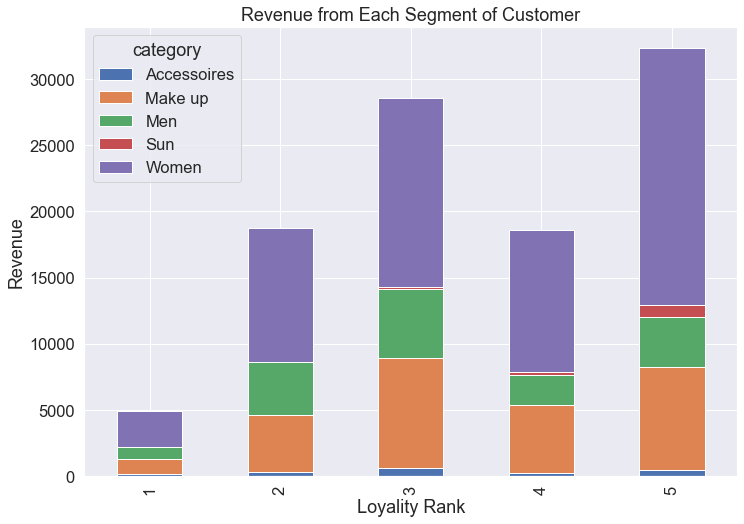

In [17]:
sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
bar1 = seg_cat_revenue.T.plot(kind='bar', stacked=True)
bar1.set_xlabel('Loyality Rank')
bar1.set_ylabel('Revenue')
bar1.set_title('Revenue from Each Segment of Customer')

Frist, we can tell there is correlation between loyalty rank and revenue, more revenue are coming from the loyal customer group. However, since we didn't normalize the number of transaction in each loyalty rank, we are not sure if this correlation is casue by "more loyal cutomer likely getting more expensive item", or simply there are more cutomers belongs to the loyal group. To take a closer look, we will have to investigate how much a loyal customer will likely spend on each transaction.


Text(0, 0.5, 'Transaction Total')

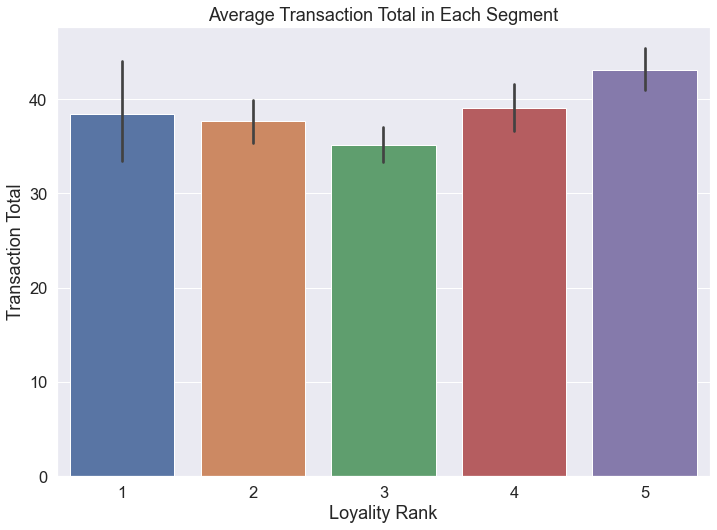

In [18]:
fig2 = sns.barplot(x='rank', y='total', data=merge_df)
fig2.set_title('Average Transaction Total in Each Segment')
fig2.set_xlabel('Loyality Rank')
fig2.set_ylabel('Transaction Total')

Here, we can concluded that a more loyal has a higher transaction total on average. Nonetheless, we cannot concluded that having more loyal customer causing more in revenue, lets look at the disturbution of customers on each loyalty level to find out.

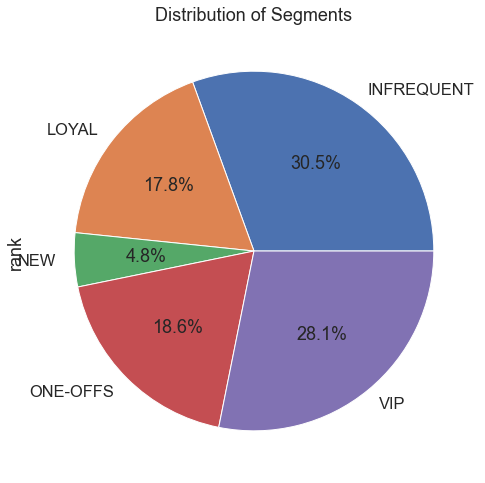

In [19]:
seg_count = merge_df.groupby('seg_name')['rank'].count()
seg_count.plot.pie(autopct='%1.1f%%').set_title('Distribution of Segments')
sns.set(font_scale=1.2)

Conclusion: As result, a more loyal customer tend to spend more money in each transaction, meaning they are buying more expensive item. Secondly, around 45% of our trandsactions are from a loyal segment. However, we have more infrequent shoppers than loyal shoppers. In order to further boost sales, I suggest creating loyalty program/marketing campaign that target infrequent customer, pushing them into a high tier of loyalty.

### 3. Category Insights

Lastly, looking at each loyalty rank, most of the revenue were coming from category Women and Make up. This is a good sign that these two categories are performing really well, making up over 80% most of the revenue, to take advantage of it, we need to look at how much listing do we have for each category so that we can make adjustment and take out some product from under performed category.

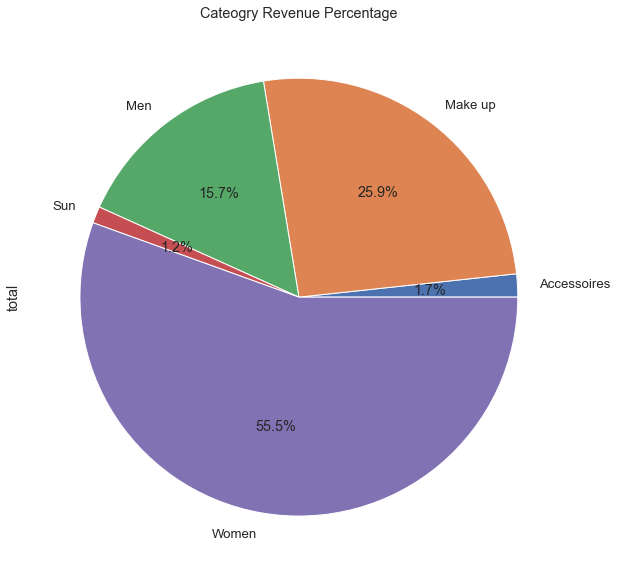

In [20]:
category_revenue_pct = merge_df.groupby('category')['total'].sum()
pie2 = category_revenue_pct.plot.pie( autopct='%1.1f%%')
pie2.set_title('Cateogry Revenue Percentage')
plt.tight_layout()

In [21]:
prod_df['category'].value_counts()

Women          821
Make up        692
Men            230
Accessoires     89
Sun             31
Name: category, dtype: int64

[Text(0.5, 1.0, 'Number of Products in Each Category')]

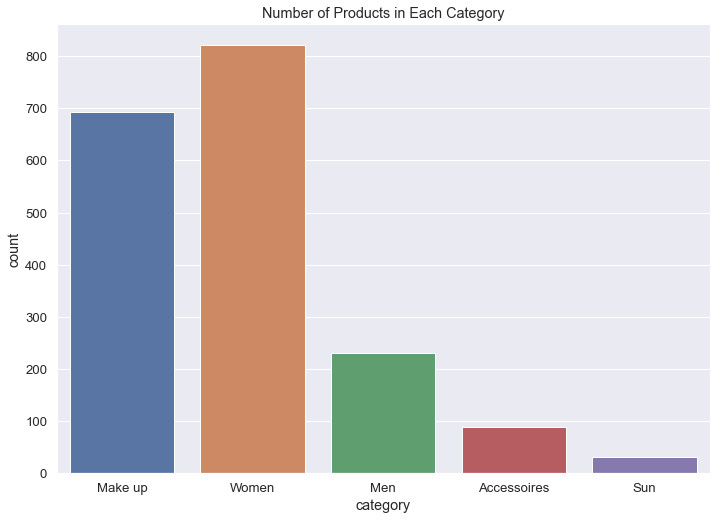

In [22]:
ccount = sns.countplot(x='category', data=prod_df)
ccount.set(title='Number of Products in Each Category')

This graph shows the number of product the shop has in differnt category. It shows that we carry a lot of product that targeted women. This shows a correlation between revenue, since we carry a lot less product in Men, Accessoires, and Sun category, we make less sale in these cateogory. This does not mean that they are underperforming in term of sale, since the number of product we carry is less for men, meaning less option for male shopper, hence, less revenue in these category as the shop's target audience is mainly women.

In [23]:
average_price = merge_df.groupby('category')[['item_price']].mean()
average_price

,item_price
category,
Accessoires,12.363406
Make up,28.030875
Men,49.504389
Sun,29.889250
Women,45.440244


Text(0.5, 0, 'Category')

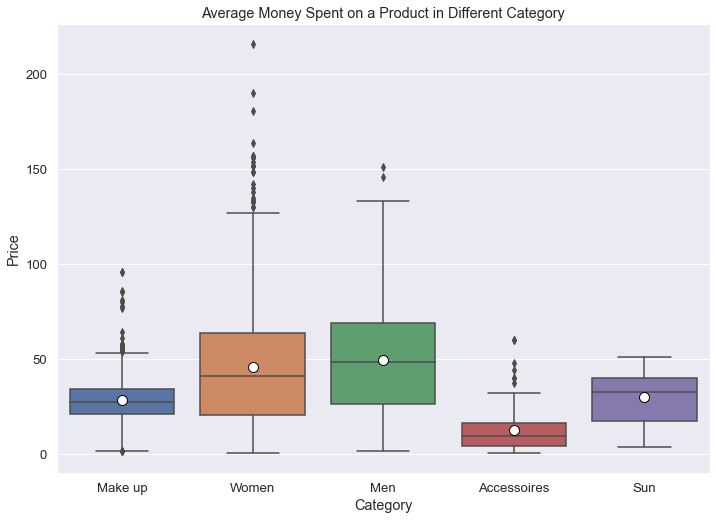

In [24]:
bar3 = sns.boxplot(x='category', y='item_price', data=merge_df, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
bar3.set_title('Average Money Spent on a Product in Different Category')
plt.ylabel('Price')
plt.xlabel('Category')

This graph shows the average money of a customer spent on an item in each category. The average money spent on a men item is not too far off compare to women, meaning that male and female are as likely to spend the same amount of money, men might be even higher. However, this can be used to explain why men category has less revenues percentage, it is because we simply do not have many men's products for male customer.